# Droplet Bounce Parameter Estimation
## Import experimental data

In [1]:
import os, fnmatch, csv
import numpy as np

class Experiment(object):
    def __init__(self, data, name, start=0, end=-1, volume=1, surfaceV=1000, frame_rate=29.95, \
                 outlier=False, threeD=False, charge=1E-11, u0=1, double=False):
        self.data = data
        self.name = name
        self.start = start
        self.end = end
        self.volume = volume
        self.surfaceV = surfaceV
        self.frame_rate = frame_rate
        self.outlier = outlier
        self.threeD = threeD
        self.charge = charge
        self.u0 = u0
        self.double = double

def import_data(exp_class):
    """
    Takes an experiment type and returns an array of Experiment class objects, with attributes specified by
    a metadata csv. The 'data' attribute The column heads include:
    'R','Area','XM','YM','Major','Minor','Angle','Circ','Slice','AR','Round','Solidity'
    """
    meta_file_location = '../data/' + exp_class + '/meta.csv'
    imported_datatype = ('U9', int, int, float, float, float, bool, bool)
    metadata = np.genfromtxt(meta_file_location, delimiter=',', dtype=imported_datatype, names=True)
    globals()[exp_class + '_data_list'] = np.array([])
    for drop in metadata:
        if drop['double']==True:
            name = 'drop' + str(drop['name'])
            path = '../data/' + exp_class + '/' + str(drop['name'][:-2:]) + '.csv'
            data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
            if name[-1::]=='1':
                data = data[0::2]
            else:
                data = data[1::2]
        else:
            name = 'drop' + str(drop['name'])
            path = '../data/' + exp_class + '/' + str(drop['name']) + '.csv'
            data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
        print(path)
        start = drop['start']
        end = drop['end']
        volume = drop['volume']
        surfaceV = drop['surfaceV']
        frame_rate = drop['frame_rate']
        outlier = drop['outlier']
        double = drop['double']
        # check for gaps
        if (data.shape[0]) < data['Slice'][-1]:
            print('there is {} cells of gap'.format((data['Slice'][-1] - data.shape[0])))
        globals()[str(name)] = Experiment(data, name, start, end, volume, surfaceV, \
                                                           frame_rate, outlier, double)
        globals()[exp_class + '_data_list'] = np.append(globals()[exp_class + '_data_list'], \
                                                        globals()[str(name)])

In [2]:
exp_class = 'dielectric_improved'
import_data(exp_class)

# use fancy indexing to make a list of outliers
mask = [datas.outlier==False for datas in dielectric_improved_data_list]
outliers = {datas.name:datas for datas in dielectric_improved_data_list[mask]}
#broken_mask = [datas.name!='drop05714' for datas in dielectric_data_list]
alldrops = {datas.name:datas for datas in dielectric_improved_data_list}

../data/dielectric_improved/07294.csv
there is 2.0 cells of gap
../data/dielectric_improved/07295.csv
../data/dielectric_improved/07296.csv
../data/dielectric_improved/07297.csv
../data/dielectric_improved/07298.csv
../data/dielectric_improved/07299.csv
../data/dielectric_improved/07300.csv
../data/dielectric_improved/07301.csv


## Filtering

In [3]:
from scipy import signal
def sg_filter(y, dt):
    try:
        if y.shape[0]>25:
            window = 25
        else:
            window = y.shape[0]
            if window % 2 ==0:
                window-=3
        return derivs(y,window,dt)
    except ValueError:
        print(window)
        
def derivs(y,window,dt):
    dtdt=dt*dt
    y_savgol = signal.savgol_filter(y, window, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, window, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, window, 3, deriv=0, axis=0)
    y_savgol3 = signal.savgol_filter(y_savgol2, window, 3, deriv=0, axis=0)
    dy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=1, axis=0)/dt
    ddy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=2, axis=0)/dtdt
    return y_savgol3, dy_savgol, ddy_savgol

##  Trajectory Plots

In [54]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pylab

%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10,10)
#matplotlib.use('pgf')

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    #"text.usetex": False,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": ['Computer Modern Sans serif'],
    "font.monospace": ['Computer Modern Typewriter'],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

%config InlineBackend.figure_formats = ['svg']
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
#matplotlib.rcParams.update(pgf_with_latex)

def trajectory(dataset, component='XM'):
    tracking = dataset.data
    a = dataset.start
    b = dataset.end
    if component in dataset.data.dtype.names:
        trackdir = component
    else:
        print("Only valid arguments are 'x' and 'y'")
        raise
    try:
        t = tracking['Slice'][a:-b]/dataset.frame_rate
        if trackdir == 'YM':
            x_zeroed = tracking['YM']
            #x_zeroed = tracking['YM']-(tracking['YM'][0]-tracking['Minor'][0]/2)
            x_points = x_zeroed[a:-b]
            x = sg_filter(x_points, t[1]-t[0])[0]
        else:
            x_points = tracking[trackdir][a:-b]
            x = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[0]
        dx = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[1]
        ddx = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[2]
        derivs=[x,dx,ddx]
        return t, derivs, x_points
    except TypeError:
        print(dataset.name)

def plotter(dataset, color, raw=False, deriv=1, component='XM'):
    (t, derivs, x_points) = trajectory(dataset, component)
    if raw==True:
        plt.plot(t,x_points, label=dataset.name, color=color)
    else:
        plt.plot(t,derivs[deriv], label=dataset.name, color=color)
    

In [55]:
def plot_series(expgroup, raw=False, deriv=1, component='XM'):
    if raw==True and deriv !=0:
        raw = False
    colors = plt.cm.Dark2(np.linspace(0,1,len(expgroup.items())))
    for keys, vals in enumerate(expgroup.items()):
        color = colors[keys]
        plotter(vals[1], color, raw, deriv, component)
    #plt.ylim((-2,2))
    plt.xlim((0.1,2))
    plt.xlabel(r't ($s$)')
    #plt.ylim((-1,.3))
    plt.ylabel(component)
    plt.legend(loc = 'best')
    plt.show()

In [56]:
#subset = {'drop07135':drop07135, 'drop07136':drop07136}

In [57]:
#for keys, vals in enumerate(alldrops.items()):
#    print(keys, vals[1])
#for keys, vals in alldrops.items():
#    print(vals)

##  Munging

In [58]:
def radius(**kwargs):
    if 'mass' in kwargs.keys():
        pass
    if 'volume' in kwargs.keys():
        return (3 * volume * 1E-6/(np.pi * 4))**(1/3.)

def mass(volume):
    return 1000 * volume * 1E-6

def volume(radius_drop):
    return 4/3*np.pi*radius_drop**3

def weber(data, ym, dt):
    surface_tension = 72.86/1000
    density = 1000
    return density*(2*np.mean(ellipse(data))/100)*(sg_filter(ym, dt)[1]/100)**2/surface_tension

In [59]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import traceback

def ellipse(data):
    YM = data['YM']
    a = data['Major']
    b = data['Minor']
    Angle = (data['Angle']-90)*np.pi/180
    return a*b/((b*np.cos(Angle))**2 + (a*np.sin(Angle))**2)**(1/2)

def ym_0(drop, n):
    ym = drop.data['YM'][drop.start:-drop.end]
    minm = signal.argrelextrema(ym, np.less, order=4)[0][::]
    maxm = signal.argrelextrema(ym, np.greater, order=1)[0][::]
    minm = np.append([0],minm)
    minm = np.append(minm, [len(ym)-1])
    intstart = minm[n]
    intend = minm[n+1]
    if minm.shape[0] == 2:
        YM_0 = 0
    else:
        YM_0 = ym[minm[1]] - ellipse(drop.data)[minm[1]]
    return YM_0, intstart, intend, minm

def get_data(drop):
    a = drop.start
    b = -drop.end
    t = drop.data['Slice'][a:b]/drop.frame_rate
    ym = drop.data['YM'][a:b]
    dt = t[1]-t[0]
    YM_0, intstart, intend, minm = ym_0(drop, n=0)
    ym = ym - YM_0
    contact = ym - ellipse(drop.data[a:b]) # distance from the bottom of the drop to YM_0
    atol = np.std(ellipse(drop.data[a:b]))*10
    above_mask = np.invert(np.isclose(contact, 0, atol=atol))
    below_zero_mask = np.invert(np.array([(contact <= 0)]))
    contact_mask = np.logical_and(above_mask, below_zero_mask).flatten()
    intendmask = np.array([(t <= t[intend])])
    intstartmask = np.array([(t >= t[intstart])])
    parted_mask = np.logical_and.reduce((intstartmask.flatten(), intendmask.flatten(), contact_mask))
    try:
        maxm = signal.argrelextrema(sg_filter(ym[parted_mask],dt)[0], np.greater, order=4)[0][::][0]
    except IndexError:
        maxm = -1
    return t[parted_mask][0:maxm], sg_filter(ym[parted_mask], dt)[0][0:maxm], \
sg_filter(ym[parted_mask], dt)[1][0:maxm]
    
def munge_plot(drop, n=0, order=2, whole_drop=False):
    a = drop.start
    b = -drop.end
    t = drop.data['Slice'][a:b]/drop.frame_rate
    ym = drop.data['YM'][a:b]
    circ = drop.data['Circ'][a:b]
    dt = t[1]-t[0]    
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    try:
        YM_0, intstart, intend, minm = ym_0(drop, n)
        ym = ym - YM_0
        # Note that YM_0 needs an absolute reference critera for drops with no bounces
        contact = ym - ellipse(drop.data[a:b]) # distance from the bottom of the drop to YM_0
        atol = np.std(ellipse(drop.data[a:b]))*10
        above_mask = np.invert(np.isclose(contact, 0, atol=atol))
        below_zero_mask = np.invert(np.array([(contact <= 0)]))
        contact_mask = np.logical_and(above_mask, below_zero_mask).flatten()
        intendmask = np.array([(t <= t[intend])])
        intstartmask = np.array([(t >= t[intstart])])
        parted_mask = np.logical_and.reduce((intstartmask.flatten(), intendmask.flatten(), contact_mask))
        maxm = signal.argrelextrema(sg_filter(ym[parted_mask],dt)[0], np.greater, order=4)[0][::]
        if maxm.shape[0]==0:
            maxm = -1
        host.plot(t[contact_mask], ym[contact_mask], 'b.')
        host.plot(t[intstart:intend],ellipse(drop.data[a:b])[intstart:intend])
    except IndexError:
        print(traceback.format_exc())
        intstart = 0
        intend = -1
        #intendmask = np.array([(t < t[intend])])
        parted_mask = (np.ones(t.shape, dtype=bool))
    
    ax2 = host.twinx()
    ax3 = host.twinx()
    host.plot(t,ym,'k-', label='Pos')
    host.plot(t[minm], ym[minm], 'go', label='minima')
    host.plot(t[parted_mask],sg_filter(ym[parted_mask], dt)[0],'r', label='Pos filtered')
    host.plot(t[parted_mask], weber(drop.data[parted_mask], ym[parted_mask], dt), label='Weber')
    host.plot(t[parted_mask][maxm], ym[parted_mask][maxm], 'co', label='maxima')
    host.set_ylabel(r'YM $cm$')
    ax2.plot(t, sg_filter(circ,dt)[0], '-', label='Circ')
    ax2.set_ylabel('Circularity')
    ax3.plot(t[parted_mask], sg_filter(ym[parted_mask], dt)[2], 'g', label='Accel')
    ax3.set_ylabel(r'Accel $cm/s^2$')
    host.set_xlabel('t (s)')
    if whole_drop==True:
        #print(radius(k.volume)*100, np.mean(ellipse(k.data[a:b])))
        interval = [t[0],t[-1]]
    else:
        interval = [t[intstart],t[intend]]
        #interval = [t_sec[0],t_sec[-1]]
    host.set_xlim(interval)

    offset = 60
    new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
    ax3.axis["right"] = new_fixed_axis(loc="right",
                                        axes=ax3,
                                        offset=(offset, 0))

    ax3.axis["right"].toggle(all=True)
    host.legend(title=drop.name, loc='best')
    plt.show()
    if whole_drop==False:
        print("Initial Weber number = {:.3f}".format(weber(drop.data[parted_mask], ym[parted_mask], dt)[0]))
        print("Impact Weber number = {:.3f}".format(weber(drop.data[parted_mask], ym[parted_mask], dt)[-1]))
        #points = np.array([t, y]).T.reshape(-1, 1, 2)
        #segments = np.concatenate([points[:-1], points[1:]], axis=1)
        plt.plot(sg_filter(ym[parted_mask], dt)[0], sg_filter(ym[parted_mask], dt)[2], 'k')
        plt.xlabel(r'YM $cm$')
        plt.ylabel(r'Accel $cm/s^2$')
        plt.show()

In [60]:
#for drop in alldrops:
#    get_data(drop)[2]
#    print("Initial Weber number = {:.3f}".format(weber(drop.data[parted_mask], ym[parted_mask], dt)[0]))

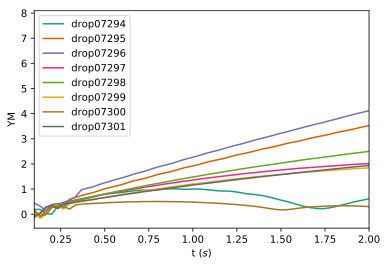

In [61]:
plot_series(alldrops, deriv=0, component='YM', raw=True)

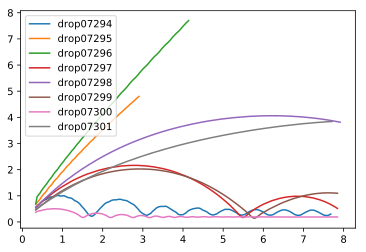

In [62]:
for keys, vals in alldrops.items():
    drop = vals
    a = drop.start+9
    b = -drop.end
    plt.plot(drop.data['Slice'][a:b]/drop.frame_rate,drop.data['YM'][a:b], label=drop.name)
    
plt.legend()
plt.show()

-3


TypeError: 'NoneType' object is not subscriptable

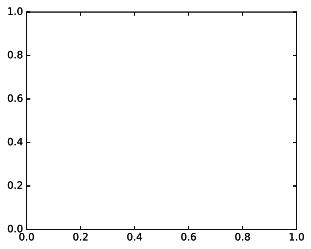

In [63]:
drop = drop07297
n_part = 0
order = 4

munge_plot(drop, order=order, n=n_part, whole_drop=True)
munge_plot(drop, order=order, n=n_part, whole_drop=False)

In [ ]:
#t, y, dy = get_data(drop)
#plt.plot(t, y)
#plt.show()

In [ ]:
#header = {'name':1,'start':2,'end':3,'volume':4,'surfaceV':5,'frame_rate':6,'outlier':7, 'double':8}
#row = !grep -n "{drop.name[4:]}" ../data/dielectric/meta2.csv | cut -d , -f 1 | cut -d : -f 1
#row = int(row[0])
#col = header['start']
#value = 1

In [ ]:
%%bash -s "$row" "$col" "$value"
#awk -v r=$1 -v c=$2 -v val=$3 -F, 'BEGIN{OFS=","}; NR != r; NR == r {$c = val; print}' \
#../data/dielectric/meta2.csv > ../data/dielectric/meta3.csv
#cp ../data/dielectric/meta3.csv ../data/dielectric/meta2.csv
#rm ../data/dielectric/meta3.csv
cat ../data/dielectric/meta2.csv

# Parameter Estimation

In [ ]:
def get_params(drop):
    V = drop.surfaceV         # superhydrophobic surface potential
    volume = drop.volume      # droplet volume
    q = 6*2.3*2E-11 *1.2      # wild-guess droplet net charge [C]
    sigma=145*1.1/3*5.5E-8    # wild-guess charge density
    t, y, dy = get_data(drop)
    t0 = t[0]                 # droplet initial time
    y0 = y[0]/100             # droplet initial position
    dy0 = dy[0]/100           # droplet initial y-velocity
    m = mass(volume)  # droplet mass [kg]
    R_drop = radius({'volume':volume})   # droplet radius
    return V, volume, q, sigma, t0, y0, dy0, m, R_drop


In [ ]:
#inputs
#V = 300
d = 2.54/100
#sigma=145*0.6/3*5.5E-8      # charge density
R = 2.54/100                 # surface radius [m] 
#q = 6*2.3*2E-11 *1.2*26     # droplet net charge [C]
#volume = 0.06 #0.065        # droplet volume [mL]
#u0 = (15.3-1)/100           # droplet initial velocity [m/s]
#puddleness = 3/2
#m = 1000 * volume * 1E-6                          #droplet mass [kg]
#R_drop = (3 * volume * 1E-6/(np.pi * 4))**(1/3.)  #droplet radius [m]
#z0 = R_drop/puddleness
V, volume, q, sigma, t0, z0, u0, m, R_drop = get_params(drop)

#physical constants
eta_0 = 8.85E-12       # vacuum permitivity 
k = 1/(4*np.pi*eta_0)  # Coulomb's constant
global k, eta_0, d, R

#print('drop radius {:.2f} cm'.format(R_drop*100))
##print(np.sqrt(q*R*sigma/eta_0))
#print('surface potential (measured) {:.2} '.format(V*eta_0/d))
#print('surface potential (model) {:.2}'.format(sigma))
#sigma = V*eta_0/d

In [ ]:
def electric_field(z, sigma, R=R):
    d = 2.54/100
    E = k * sigma * 2 * np.pi * (1 - z/np.sqrt(z**2. + R**2.))
    del_E2 = 2 * (k * sigma * 2 * np.pi)**2. * R**2. * (z - np.sqrt(R**2. + z**2.))/(R**2. + z**2.)**2.
    V = k * sigma * 2 * np.pi * (np.sqrt(z**2. + R**2.) - z)
    E_sqr = 4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2)))
    del_E_sqr2 = 32* k**2 *((-2* d**2)/(2 *d**2 + 4 *z**2)**(3/2) - d**2/(2 *z**2 *np.sqrt(2 *d**2 + 4* z**2))\
                            *sigma**2 *np.arctan(d**2/(2 *z *np.sqrt(2* d**2 + 4* z**2))))\
    /(1 + d**4/(4* z**2 *(2 *d**2 + 4 *z**2)))
    return E, del_E2, V, E_sqr, del_E_sqr2

print('Simulated fieldmeter reading -{:.2f} kV'.format(electric_field(2.54/100, sigma)[2]/1000))
print('Simulated fieldmeter reading -{:.2f} kV/m'.format(electric_field(2.54/100, sigma)[0]/1000))

# Plot the results
#from matplotlib import rc
#import pylab
#%config InlineBackend.figure_formats=['svg']
#%matplotlib inline
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

zz = np.linspace(0.00001, 3./100, 1000)              
#zz = np.linspace(0, 4, 1000)
plt.semilogx(zz*1000, electric_field(zz, sigma)[2]/1000)
plt.xlabel('z ($cm$)')
plt.ylabel('Scalar Potential ($kV$)')
#plt.autoscale(enable=True, axis='x', tight=True)
plt.yticks([2,3,4])
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(zz*100, electric_field(zz, sigma)[0]/1000, zz*100, electric_field(zz, sigma)[3]/1000)
ax2 = ax1.twinx()
ax2.plot(zz*100, np.multiply(electric_field(zz, sigma)[3],zz)/1000, 'r')
ax1.set_xlabel('z ($cm$)')
ax1.set_ylabel('Electric field ($kV/m$)')
ax2.set_ylabel('Surface Voltage E*d ($kV$)')
plt.show()

plt.semilogy(zz*100, np.abs(electric_field(zz, sigma)[1]/1000), zz*100, np.abs(electric_field(zz, sigma)[4]/1000))
plt.show()

In [ ]:
def force_ep(z, q, sigma):
    eta_a=3
    im = -1/(16*np.pi*1*eta_0)*(1-eta_a)/(1+eta_a)*q**2/z**2
    return q * electric_field(z, sigma)[3] + im

def force_dep(z, R_drop):
    eta_air = 1.
    eta_water = 90.
    K = (eta_water - eta_air)/(eta_water + 2 * eta_air)
    #return -2 * np.pi * R_drop**3. * eta_air * K * eta_0 * electric_field(z)[4]
    return 0
    
def reynolds(v, R_drop):
    nu = 15.11E-6
    D = R_drop * 2
    return D*np.abs(v)/nu

def drag(v, R_drop):
    rho = 1.225
    Cd = 24/reynolds(v, R_drop) + 5/np.sqrt(reynolds(v, R_drop)) + 0.3
    return Cd*2*rho*np.pi*R_drop**2*v**2
    
#print('DEP {}'.format(force_dep(R_drop/3)))
#print('EP {}'.format(force_ep(R_drop/3)))

In [ ]:
#x = np.array([R_drop/puddleness]).tolist()
#v = [u0]
#t = [0]
#EP = [force_ep(x[0])]
#DEP = [force_dep(x[0])]
#a = [(-EP[0] - DEP[0])/m]
#re = [reynolds(v[0])]
#drg = [drag(v[0])]
#
#dt = 0.00001
#    
#while x[-1] >= R_drop/puddleness and t[-1] <= 1.6:
#    a.append((-EP[-1] - DEP[-1] - drg[-1])/m)
#    v.append(a[-1]*dt + v[-1])
#    x.append(v[-1]*dt + x[-1])
#    EP.append(force_ep(x[-1]))
#    DEP.append(force_dep(x[-1]))
#    re.append(reynolds(v[-1]))
#    drg.append(drag(v[-1]))
#    t.append(t[-1] + dt)
#
#EP  = np.array(EP)
#DEP = np.array(DEP)
#a   = np.array(a)
#v   = np.array(v)
#x   = np.array(x)
#t   = np.array(t)
#re  = np.array(re)
#
## plotting
#pylab.rcParams['figure.figsize'] = (8.0, 15.0)
#f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True)
#ax1.plot(t, v*100, t, exp_data(t)[0])
#ax1.set_ylabel("Velocity (cm/s)")
#ax2.plot(t, x*100, t, exp_data(t)[2])
#ax2.set_ylabel("Position (cm)")
#ax3.plot(t, a*100, t, exp_data(t)[1])
#ax3.set_ylabel("Acceleration (cm/s^2)")
#ax6.plot(t, EP/DEP)
#ax6.set_ylabel("Force ratio")
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax4.plot(t, DEP)
#ax4.set_ylabel("Dielectrophoresis force (N)")
#ax5.plot(t, EP)
#ax5.set_ylabel("Electrophoresis force (N)")
#ax7.plot(t, re)
#ax8.plot(t, drg)
#ax6.set_xlabel("t (s)")
#f.tight_layout()
#plt.show()

In [ ]:
#plt.figure(figsize=(9,5))
#plt.plot(x*100, a*100, x*100, exp_data(t)[1])
#plt.show

In [ ]:
import scipy.integrate as integrate
from scipy import stats

def f(y, t, params):
    z, u = y      # unpack current values of y
    m, R_drop, sigma, q = params # unpack parameters   
    derivs = [u, (-force_dep(z, R_drop) - force_ep(z, q, sigma) - drag(u, R_drop))/m] # list of dy/dt=f functions
    return derivs

def get_model(*args):
    V, volume, q, sigma, t0, z0, u0, m, R_drop = args[0]
    
    # Initial values
    z0 = z0    # initial displacement
    u0 = u0    # initial velocity
    t0 = t0    # initial time

    # Bundle parameters for ODE solver
    params = (m, R_drop, sigma, q/3.3)
    #print('Droplet charge {:.2} C'.format(params[3]))
    
    # Bundle initial conditions for ODE solver
    y0 = [z0, u0]

    # Make time array for solution
    tStop = get_data(drop)[0][-1]
    tInc = 0.0005
    t_rk = np.arange(t0, tStop, tInc)

    # Call the ODE solver
    psoln = integrate.odeint(f, y0, t_rk, args=(params,))
    return psoln, t_rk

In [ ]:
##ODE_mask = ([psoln[:,0]>=0])
#psoln, t_rk = get_model(get_params(drop))
#t, y, dy = get_data(drop)
#
#
#y_soln = np.array([])
#for times in t:
#    y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]*100))
##print(len(y_soln), len(t))
#print(stats.chisquare(y,f_exp=y_soln,axis=0))
#
## Plot results
#fig = plt.figure(1, figsize=(8,8))
#
## Plot theta as a function of time
#ax1 = fig.add_subplot(311)
##ax1.plot(t_rk[ODE_mask], psoln[:,0][ODE_mask], label='model')
##ax1.plot(t_rk, psoln[:,0]*100, label='model')
#ax1.plot(t, y, '+', label='data')
#ax1.plot(t,y_soln, label='model')
##ax1.plot(t_rk[ODE_mask], psoln[ODE_mask]*100)
#ax1.legend(title=drop.name)
#ax1.set_xlabel('time')
#ax1.set_ylabel('position')
#
## Plot omega as a function of time
##ax2 = fig.add_subplot(312)
##ax2.plot(t_rk[ODE_mask], psoln[:,1][ODE_mask]*100, t_rk, exp_data(t_rk)[0])
##ax2.set_xlabel('time')
##ax2.set_ylabel('velocity')
#
#plt.tight_layout()
#plt.show()

In [ ]:
# Plot omega vs theta
#plt.figure(figsize=(9,5))
#plt.plot(psoln[:,0], psoln[:,1], '.', ms=1)
#plt.xlabel('z (cm)')
#plt.ylabel('u (cm/s)')
#plt.show()

In [ ]:
## Pseudo-objective function
#global cons_TWR, cons_S_crit, cons_accel, cons_LD, cons_alt
#
##CHANGE CONSTRAINTS HERE
#cons_TWR = 8       # TWR constraint
#cons_S_crit = 0.35 # Critical pressure ratio constraint
#cons_accel = 15    # Max acceleration constraint
#cons_LD = 15       # L/D ratio constraint
#cons_alt = 100000  # Min altitude constraint
#
#def f(x, p_ch=350, rp=50): ##CHANGE CHAMBER PRESSURE HERE
#    L = x[0]    # Rocket length (m)
#    mdot = x[1] # Propellant mass flow rate (kg/s)
#    dia = x[2]  # Rocket diameter (in)
#    p_e = x[3]  # Pressure (kPa)
#    (alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) \
#    = trajectory(L, mdot, dia, p_e, p_ch)
#
#
#    obj_func = m[0]/m0 + rp*(max(0, (L+2)/(dia*0.0254*cons_LD) - 1)**2 + \
#               max(0, -TWR/cons_TWR + 1)**2 + max(0, -S_crit/cons_S_crit + 1)**2 + \
#                             max(0, -alt[-1]/cons_alt + 1)**2 + max(0, max(abs(a))/(cons_accel*9.81) - 1)**2)
#    return obj_func

In [ ]:
###CHANGE INITIAL DESIGN GUESS HERE
#L = 1.5    # Rocket length (m)
#mdot = 0.453592 * 0.9 * 5 # Propellant mass flow rate (kg/s)
#dia = 9  # Rocket diameter (in)
#p_e = 40  # Pressure (kPa)
#X0 = np.array([L, mdot, dia, p_e])
#m0 = trajectory(X0[0], X0[1], X0[2], X0[3])[-4][0] # Initial guess GLOW
#
#from scipy.optimize import minimize
#res = minimize(f, X0, method='nelder-mead')

In [ ]:
from scipy.optimize import minimize

def obj_func(params):
    #constraints = V, volume, q, sigma, t0, z0, u0, m, R_drop
    #print(params)
    psoln, t_rk = get_model(params)
    t, y, dy = get_data(drop)
    y_soln = np.array([])
    for times in t:
        y_soln = np.append(y_soln,np.interp(times,t_rk, psoln[:,0]*100))
    rp = 50
    return stats.chisquare(y,f_exp=y_soln,axis=0)[0] + rp*(0)
    
def res(drop):
    #V, volume, q, sigma, t0, z0, u0, m, R_drop = get_params(drop)
    X0 = np.asarray(get_params(drop))
    return minimize(obj_func, X0, method='nelder-mead')

In [ ]:
result = res(drop)

In [ ]:
psoln, t_rk = get_model(result.x)
t, y, dy = get_data(drop)

y_soln = np.array([])
for times in t:
    y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]*100))

# Plot results
fig = plt.figure(1, figsize=(8,8))

# Plot theta as a function of time
ax1 = fig.add_subplot(311)
#ax1.plot(t_rk[ODE_mask], psoln[:,0][ODE_mask], label='model')
#ax1.plot(t_rk, psoln[:,0]*100, label='model')
ax1.plot(t[::5], y[::5], 'ko', label='data')
ax1.plot(t,y_soln, 'r', label='model')
#ax1.plot(t_rk[ODE_mask], psoln[ODE_mask]*100)
ax1.legend(title=drop.name)
ax1.set_xlabel('time')
ax1.set_ylabel('position')
plt.tight_layout()
plt.show()

In [ ]:
print('Droplet charge {:.2} C'.format(result.x[2]))
print(stats.chisquare(y,f_exp=y_soln,axis=0))

In [ ]:
comp_params = get_params(drop)
print('nit', result.nit)
names = ['V', 'volume', 'q', 'sigma', 't0', 'z0', 'u0', 'm', 'R_drop']
result.x[1]=volume(result.x[8])

for n in range(len(result.x)):
    print('{}  {:.3}  {:.3}'.format(names[n], result.x[n], comp_params[n]))

In [ ]:
#from sympy import *
#init_printing()
#
#y, z, nu, a = symbols('y z nu a')
#nu*integrate(z/((z**2 + y**2)*sqrt(z**2 + y**2 + a**2/4)), (y,0,a/2))

In [ ]:
# relating apparent contact angle hysteresis to 
# roll-off angle using the model of Furmidge, J. Colloid Sci. 1962, 17, 309.
# 2 mL data for DDT surfaces

%config InlineBackend.figure_formats = ['pdf']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams.update(pgf_with_latex)

n = np.linspace(5,25,5)
a = np.linspace(130,180,100)
const = -10
colors = plt.cm.cool_r(np.linspace(0,1,len(n)))

for k,i in np.ndenumerate(n):
    b = a - i
    hyster = np.arcsin(np.cos(a*np.pi/180)-np.cos(b*np.pi/180))
    plt.plot(a, const*hyster, label=int(i), color=colors[k], zorder=1)

exp_roll_off = 2.8
exp_CA_appar = 148
plt.scatter([exp_CA_appar,138],[exp_roll_off,2],100, marker="v", facecolors='r', edgecolors='m', zorder=2)
plt.annotate('laser-etched PMMA ($R_q \sim 775 \mu m$)', xy=(exp_CA_appar,exp_roll_off), xycoords='data', 
            xytext=(15, 30), textcoords='offset points', fontsize=10, 
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.47"))
plt.annotate('', xy=(138,2), xycoords='data', 
            xytext=(85,74), textcoords='offset points', fontsize=10, 
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))

plt.scatter([158,],[2,],100, marker="o", facecolors='b', edgecolors='c', zorder=2)
plt.annotate('sandpaper ($R_q \sim 30 \mu m$)', xy=(158,2), xycoords='data', 
            xytext=(-10, 40), textcoords='offset points', fontsize=10, 
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))

plt.legend(title=r'$\theta_a - \theta_r$', loc='upper right')
axes = plt.gca()
axes.set_xlim(135,180)
plt.xticks([140,150, 160,170, 180])
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$\theta_a$')
plt.show()

Probably need more reliable data, but it looks like the hysteresis is similar for the sandpaper and laser-etched PMMA surfaces (or at least the PMMA has a much larger variance in apparent contact angle and roll-off angle).

In [ ]:
x = np.linspace(0,5,100)
cmap = plt.get_cmap('ocean')
N=20
for i,n in enumerate(np.linspace(2.0,0,N)):
    y = np.sin(x)*x**n
    color = cmap(float(i)/N)
    #lw = 2.5 if i==0 else 1
    plt.plot(x,y, color=color, zorder=-i)
plt.show()